# Movie recommendation systeme : content-based

source : https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv , Data collected from JustWatch. 
MovieId, title, 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report

## Step 1 : Files importation

In [308]:
# Lecture des fichiers CSV et formatage initial
df = pd.read_csv('input/titles.csv')

In [310]:
df.head(5)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [16]:
len(df)

5850

## Step 2 : Data formatting

In [ ]:
# only movie : filter type - seasons drop

In [312]:
df = df[df['type']=='MOVIE']
df = df.drop(['type','seasons','age_certification','imdb_id','id'], axis=1)
df = df.reset_index(drop=True)

In [314]:
df.head(3)

,title,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
1,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
2,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811


In [123]:
len(df)

3744

### Keyword extraction

ref article : https://www.analyticsvidhya.com/blog/2022/01/four-of-the-easiest-and-most-effective-methods-of-keyword-extraction-from-a-single-text-using-python/  
Yake: Campos, Ricardo, et al. “YAKE! Keyword extraction from single documents using multiple local features.” Information Sciences 509 (2020): 257-289.

In [336]:
df = df.dropna(subset=['title', 'description'])

In [ ]:
pip install git+https://github.com/LIAAD/yake

In [256]:
import yake

In [379]:
def extract_keywords(title, text):
    combined_text = title + " " + text
    kw_extractor = yake.KeywordExtractor(top=5, stopwords=None, n=1)
    keywords = kw_extractor.extract_keywords(combined_text)
    # Extraire seulement les mots-clés, ignorer les scores
    return [kw for kw, v in keywords]

In [381]:
df['keywords'] = df.apply(lambda row: extract_keywords(row['title'], row['description']), axis=1)

In [383]:
df['keywords']

0                     [Driver, Vietnam, War, York, City]
1          [Intent, Cahulawassee, River, Lewis, Medlock]
2                      [Sir, Arthur, Table, Wise, Brave]
3                   [Dozen, American, Dirty, World, War]
4                   [Messiah, Brian, Cohen, Jewish, man]
                              ...                       
3739              [Empire, Bling, Afterparty, Joel, Kim]
3740                 [Wine, Fine, gaps, beautiful, love]
3741              [Kaadhal, group, heart, warming, film]
3742    [Lokillo, dealer, controversial, host, comedian]
3743       [Foxx, David, Stop, Embarrassing, Afterparty]
Name: keywords, Length: 3735, dtype: object

### Genre

In [361]:
import ast

In [389]:
df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
df_exploded = df.explode('genres')

In [393]:
genre_counts = df_exploded['genres'].value_counts()
genre_counts

genres
drama            1874
comedy           1570
thriller          824
action            718
romance           698
documentation     610
crime             545
family            351
european          344
fantasy           315
animation         281
horror            260
scifi             204
music             191
history           145
sport             113
war               103
western            28
reality             9
Name: count, dtype: int64

In [399]:
df_exploded

,title,description,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,keywords
0,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,drama,['US'],8.2,808582.0,40.965,8.179,"[Driver, Vietnam, War, York, City]"
0,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,114,crime,['US'],8.2,808582.0,40.965,8.179,"[Driver, Vietnam, War, York, City]"
1,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,drama,['US'],7.7,107673.0,10.010,7.300,"[Intent, Cahulawassee, River, Lewis, Medlock]"
1,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,action,['US'],7.7,107673.0,10.010,7.300,"[Intent, Cahulawassee, River, Lewis, Medlock]"
1,Deliverance,Intent on seeing the Cahulawassee River before...,1972,109,thriller,['US'],7.7,107673.0,10.010,7.300,"[Intent, Cahulawassee, River, Lewis, Medlock]"
...,...,...,...,...,...,...,...,...,...,...,...
3740,Fine Wine,A beautiful love story that can happen between...,2021,100,romance,['NG'],6.8,45.0,1.466,NaN,"[Wine, Fine, gaps, beautiful, love]"
3740,Fine Wine,A beautiful love story that can happen between...,2021,100,drama,['NG'],6.8,45.0,1.466,NaN,"[Wine, Fine, gaps, beautiful, love]"
3741,C/O Kaadhal,A heart warming film that explores the concept...,2021,134,drama,[],7.7,348.0,NaN,NaN,"[Kaadhal, group, heart, warming, film]"
3742,Lokillo,A controversial TV host and comedian who has b...,2021,90,comedy,['CO'],3.8,68.0,26.005,6.300,"[Lokillo, dealer, controversial, host, comedian]"


## Step 3 : Missing values

In [125]:
df.isnull().sum()

id                         0
title                      1
description                9
release_year               0
age_certification       2364
runtime                    0
genres                     0
production_countries       0
imdb_id                  262
imdb_score               315
imdb_votes               331
tmdb_popularity           62
tmdb_score               195
dtype: int64

In [170]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()
    
    return per_nan

In [172]:
percent_missing(df)

title                 0.026709
description           0.240385
tmdb_popularity       1.655983
tmdb_score            5.208333
imdb_id               6.997863
imdb_score            8.413462
imdb_votes            8.840812
age_certification    63.141026
dtype: float64

## Missing value

In [174]:
df = df.dropna(subset=['title', 'description'])

In [134]:
percent_missing(df)

tmdb_popularity       1.526104
tmdb_score            5.087015
imdb_id               6.907631
imdb_score            8.299866
imdb_votes            8.701473
age_certification    63.078983
dtype: float64

In [138]:
percent_missing(df)

tmdb_popularity    1.526104
tmdb_score         5.087015
imdb_score         8.299866
imdb_votes         8.701473
dtype: float64

In [178]:
df['tmdb_score'].describe()

count    3545.000000
mean        6.462956
std         1.042384
min         1.000000
25%         5.900000
50%         6.500000
75%         7.100000
max        10.000000
Name: tmdb_score, dtype: float64

In [180]:
df['imdb_score'].describe()

count    3425.000000
mean        6.247533
std         1.126668
min         1.500000
25%         5.600000
50%         6.400000
75%         7.100000
max         9.100000
Name: imdb_score, dtype: float64

<Axes: xlabel='imdb_score', ylabel='Count'>

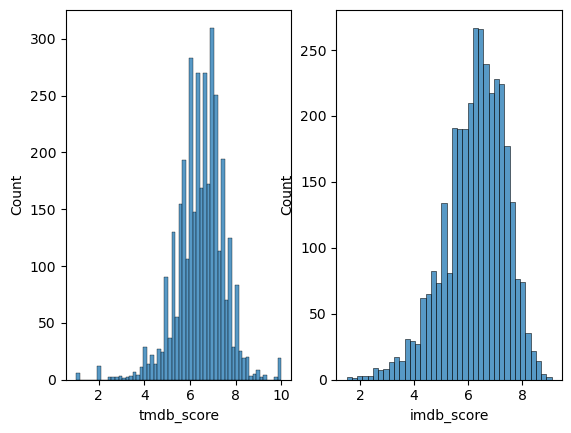

In [182]:
fig,axes = plt.subplots(nrows=1,ncols=2)
sns.histplot(df.tmdb_score, ax = axes[0])
sns.histplot(df.imdb_score, ax = axes[1])

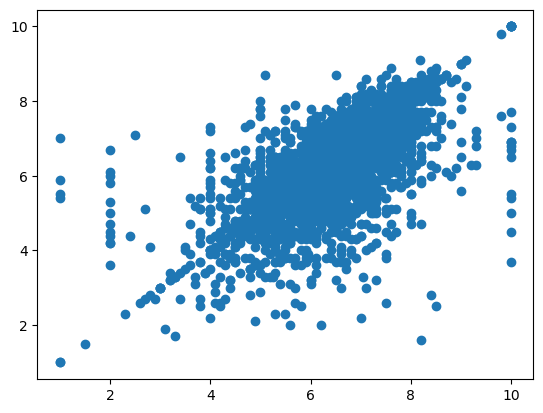

In [188]:
plt.scatter(df['tmdb_score'],df['imdb_score'])

In [186]:
df['tmdb_score'] = df['tmdb_score'].fillna(df['imdb_score'])
df['imdb_score'] = df['imdb_score'].fillna(df['tmdb_score'])

In [190]:
percent_missing(df)

imdb_score         1.311914
tmdb_score         1.311914
tmdb_popularity    1.526104
imdb_votes         8.701473
dtype: float64

### Completing missing value by predictions with machine learning

In [207]:
# Séparer les lignes complètes et incomplètes
train_data = df.dropna()
test_data = df[df.isnull().any(axis=1)]

In [215]:
from sklearn.ensemble import RandomForestRegressor

In [223]:
df_model = df[["release_year","runtime","genres","production_countries","imdb_score","imdb_votes","tmdb_popularity","tmdb_score"]]

In [225]:
train_data = df_model.dropna(subset=['tmdb_score'])
test_data = df_model[df_model['tmdb_score'].isnull()]

In [227]:
models = {}
for column in ['imdb_score', 'tmdb_score', 'tmdb_popularity', 'imdb_votes']:
    X_train = train_data.drop(columns=[column])
    y_train = train_data[column]
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    models[column] = model

ValueError: could not convert string to float: "['drama', 'crime']"

In [196]:
# Définir les features et la target pour le modèle
X_train = train_data[['imdb_score']]
y_train = train_data['tmdb_score']
X_test = test_data[['imdb_score']]

In [198]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [200]:
predictions = model.predict(X_test)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [17]:
def data_slicing_customer(df):
    df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count']).compute()
    df_cust_summary.index = df_cust_summary.index.map(int)
    cust_benchmark = round(df_cust_summary['count'].quantile(0.25),0)
    drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
    print(f"customer who have less than {cust_benchmark} ratings will be dropped")
    df = df[~df['Cust_Id'].isin(drop_cust_list)]
    return df

In [19]:
#unpopular film deletion less than q25 counts rating (only purpose to alleged the files - but let's say for the purpose of dropping them without any popularity backlash)
def data_slicing_movie(df):
    df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count']).compute()
    df_movie_summary.index = df_movie_summary.index.map(int)
    movie_benchmark = round(df_movie_summary['count'].quantile(0.25),0)
    drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
    print(f"movie who have less than {movie_benchmark} ratings will be dropped")
    df = df[~df['Movie_Id'].isin(drop_movie_list)]
    return df

In [21]:
df_customers = data_slicing_customer(df_customers)

customer who have less than 39.0 ratings will be dropped


In [23]:
df_customers = data_slicing_movie(df_customers)

movie who have less than 2840.0 ratings will be dropped


In [ ]:
# There is erros in the csv Title : probleme is that they put virgule inside : used only the begininng of the title
# Second probel : read_csv don't read ' "" ', or some title seems to have it (easiest way : CTRL+F in the csv, only 6 occurences)

In [61]:
df_movie_name = dd.read_csv('input/movie_titles.csv', 
                            encoding="ISO-8859-1", 
                            header=None, 
                            names=['Movie_Id', 'Year', 'Name'],
                            dtype={'Movie_Id': 'int64', 'Year': 'float', 'Name': 'object'}, usecols = [0,1,2])

In [71]:
df_movie_name.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [73]:
df_combined = dd.merge(df_customers, df_movie_name, how='inner', on='Movie_Id')

In [75]:
df_combined.compute().iloc[0]

Cust_Id       1025579
Rating            4.0
Movie_Id            3
Year           1997.0
Name        Character
Name: 0, dtype: object

## EDA

In [35]:
df_combine_describe = df_combined.describe().compute()
df_combine_describe

,Rating,Movie_Id,Year
count,9.876119e+07,9.876119e+07,9.876119e+07
mean,3.610411e+00,2.216522e+03,1.990519e+03
std,1.081735e+00,1.269288e+03,1.663832e+01
min,1.000000e+00,3.000000e+00,1.915000e+03
25%,3.000000e+00,1.149000e+03,1.994000e+03
50%,4.000000e+00,2.193000e+03,2.000000e+03
75%,5.000000e+00,3.329000e+03,2.003000e+03
max,5.000000e+00,4.709000e+03,2.005000e+03


In [81]:
#distribution des notes
rating_counts = df_combined['Rating'].value_counts().compute()
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ['Rating', 'Count']
# Calculer les pourcentages
total_count = rating_counts_df['Count'].sum()
rating_counts_df['Percentage'] = (rating_counts_df['Count'] / total_count) * 100
# Trier les valeurs pour que les barres correspondent
rating_counts_df = rating_counts_df.sort_values('Rating')

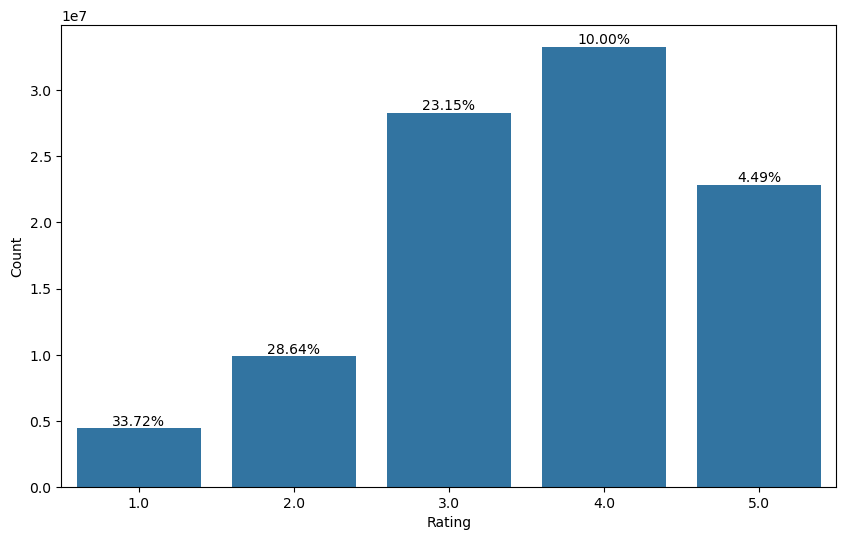

In [79]:
# Tracer un barplot avec les données agrégées
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=rating_counts_df, x='Rating', y='Count')

# Ajouter les pourcentages sur chaque barre
for index, row in rating_counts_df.iterrows():
    bar = barplot.patches[index]
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
        f"{row['Percentage']:.2f}%",
        color='black',
        ha="center",
        va="bottom"
    )


In [477]:
top_movies = df_combined.groupby('Title')['Rating'].mean().nlargest(10).compute()
top_movies

Title
Damn the Defiant                                 4.645549
Night of the Hunted                              4.568930
Tank Girl                                        4.548398
Irreversible                                     4.531854
Dirty Tiger                                      4.500427
Boys Life 4: Four Play                           4.488026
Tales of Terror                                  4.484326
The Simpsons: Season 6                           4.483073
Walt Disney's Timeless Tales: Vol. 2             4.462211
Lord of the Rings: The Fellowship of the Ring    4.442368
Name: Rating, dtype: float64

In [481]:
ratings_count = df_combined.groupby('Title')['Rating'].count().nlargest(10).compute()
ratings_count

Title
Logan's Run                    304284
Cadfael: The Potter's Field    257782
Braveheart                     232480
The Testament of Dr. Mabuse    223819
The Lord of the Rings          222497
Kickboxer                      215799
The Toy                        215000
Sex and the Teenage Mind       207776
Two's Company: Series 1        205831
About Schmidt                  202132
Name: Rating, dtype: int64

## KNN pour recommendation de film

In [83]:
df_combined.dtypes

Cust_Id     string[pyarrow]
Rating              float64
Movie_Id              int32
Year                float64
Name        string[pyarrow]
dtype: object

In [97]:
# Conversion de Cust_Id en catégorie et s'assurer que les catégories sont connues
df_combined['Cust_Id'] = df_combined['Cust_Id'].astype('category')
df_combined = df_combined.categorize(columns=['Cust_Id'])

In [99]:
# Encodage de 'Cust_Id' en numérique
df_combined['Cust_Id'] = df_combined['Cust_Id'].cat.codes

In [118]:
X = df_combined[['Cust_Id','Movie_Id']].compute()
y = df_combined['Rating'].compute()

In [ ]:
### sous-echantillonage : 10% données pour trouver les bon param

In [152]:
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.90, random_state=42)

In [154]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sample, y_sample, test_size=0.10, random_state=42)

In [156]:
knn_model_sample = KNeighborsRegressor(n_neighbors=5, metric='cosine')

In [158]:
knn_model_sample.fit(X_train_s, y_train_s)

KNeighborsRegressor(metric='cosine')

In [160]:
predictions_sample = knn_model_sample.predict(X_test_s)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test_s, predictions_sample))

In [ ]:
# entrainement sur l'entiereté du modele : dask_ml

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [142]:
knn_model = KNeighborsRegressor(n_neighbors=5, metric='cosine')

In [144]:
knn_model.fit(X_train,y_train)

KNeighborsRegressor(metric='cosine')

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))